# <font color="#1b5776">1. <u>Adding Imports</u></font>

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression,Lasso
from xgboost import XGBClassifier,XGBRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier,LGBMRegressor

from sklearn.metrics import mean_squared_error
import pickle

from prettytable import PrettyTable
from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

# <font color="#1b5776">2. <u>Getting the Data</u></font>

In [6]:
train = pd.read_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/train_new_visitor_level.csv",dtype={"fullVisitorId":"str"})

test = pd.read_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/test_new_visitor_level.csv",dtype={"fullVisitorId":"str"})

In [7]:
print("train shape:",train.shape)
print("test shape:",test.shape)

train shape: (1417575, 119)
test shape: (296530, 118)


In [8]:
train.head(2)

,fullVisitorId,channelGrouping_ModeMax,date_Span,visitNumber_ModeMax,visitNumber_Median,visitNumber_Mean,visitNumber_Sum,visitNumber_Min,visitNumber_Max,device_browser_ModeMax,device_operatingSystem_ModeMax,device_isMobile_ModeMax,device_deviceCategory_ModeMax,geoNetwork_continent_ModeMax,geoNetwork_subContinent_ModeMax,geoNetwork_country_ModeMax,geoNetwork_region_ModeMax,geoNetwork_metro_ModeMax,geoNetwork_city_ModeMax,geoNetwork_networkDomain_ModeMax,totals_hits_Median,totals_hits_Mean,totals_hits_Sum,totals_hits_Min,totals_hits_Max,totals_pageviews_Median,totals_pageviews_Mean,totals_pageviews_Sum,totals_pageviews_Min,totals_pageviews_Max,totals_sessionQualityDim_Median,totals_sessionQualityDim_Mean,totals_sessionQualityDim_Sum,totals_sessionQualityDim_Min,totals_sessionQualityDim_Max,totals_timeOnSite_Median,totals_timeOnSite_Mean,totals_timeOnSite_Sum,totals_timeOnSite_Min,totals_timeOnSite_Max,...,weekOfYear_Mean,weekOfYear_Sum,weekOfYear_Min,weekOfYear_Max,dayOfYear_ModeMax,dayOfYear_Median,dayOfYear_Mean,dayOfYear_Sum,dayOfYear_Min,dayOfYear_Max,quarter_ModeMax,quarter_Median,quarter_Mean,quarter_Sum,quarter_Min,quarter_Max,isYearEnd_ModeMax,is_weekend_ModeMax,visit_hr_ModeMax,visit_hr_Median,visit_hr_Mean,visit_hr_Sum,visit_hr_Min,visit_hr_Max,visit_min_Median,visit_min_Mean,visit_min_Sum,visit_min_Min,visit_min_Max,visit_sec_Median,visit_sec_Mean,visit_sec_Sum,visit_sec_Min,visit_sec_Max,time_of_day_ModeMax,is_office_hours_ModeMax,returnedPostGap,totals_transactionRevenue_LogOfSum,firstVisit_AfterStart,lastVisit_BeforeEnd
0,0000010278554503158,7,0,1,1.0,1.0,1.0,1,1,21,13,1,2,3,0,15,94,26,119,406,3.0,3.0,3.0,3,3,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,61.0,61.0,61.0,61.0,61.0,...,42.0,42.0,42,42,294,294.0,294.0,294.0,294,294,4,4.0,4.0,4.0,4,4,0,1,5,5.0,5.0,5.0,5,5,57.0,57.0,57.0,57,57,46.0,46.0,46.0,46,46,1,1,0,0.0,80,87
1,0000020424342248747,7,0,1,1.0,1.0,1.0,1,1,20,10,0,1,4,17,47,61,26,74,1349,4.0,4.0,4.0,4,4,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,51.0,51.0,51.0,51.0,51.0,...,48.0,48.0,48,48,335,335.0,335.0,335.0,335,335,4,4.0,4.0,4.0,4,4,0,1,7,7.0,7.0,7.0,7,7,55.0,55.0,55.0,55,55,1.0,1.0,1.0,1,1,0,1,0,0.0,121,46


In [9]:
test.head(2)

,fullVisitorId,channelGrouping_ModeMax,date_Span,visitNumber_ModeMax,visitNumber_Median,visitNumber_Mean,visitNumber_Sum,visitNumber_Min,visitNumber_Max,device_browser_ModeMax,device_operatingSystem_ModeMax,device_isMobile_ModeMax,device_deviceCategory_ModeMax,geoNetwork_continent_ModeMax,geoNetwork_subContinent_ModeMax,geoNetwork_country_ModeMax,geoNetwork_region_ModeMax,geoNetwork_metro_ModeMax,geoNetwork_city_ModeMax,geoNetwork_networkDomain_ModeMax,totals_hits_Median,totals_hits_Mean,totals_hits_Sum,totals_hits_Min,totals_hits_Max,totals_pageviews_Median,totals_pageviews_Mean,totals_pageviews_Sum,totals_pageviews_Min,totals_pageviews_Max,totals_sessionQualityDim_Median,totals_sessionQualityDim_Mean,totals_sessionQualityDim_Sum,totals_sessionQualityDim_Min,totals_sessionQualityDim_Max,totals_timeOnSite_Median,totals_timeOnSite_Mean,totals_timeOnSite_Sum,totals_timeOnSite_Min,totals_timeOnSite_Max,...,weekOfYear_Median,weekOfYear_Mean,weekOfYear_Sum,weekOfYear_Min,weekOfYear_Max,dayOfYear_ModeMax,dayOfYear_Median,dayOfYear_Mean,dayOfYear_Sum,dayOfYear_Min,dayOfYear_Max,quarter_ModeMax,quarter_Median,quarter_Mean,quarter_Sum,quarter_Min,quarter_Max,isYearEnd_ModeMax,is_weekend_ModeMax,visit_hr_ModeMax,visit_hr_Median,visit_hr_Mean,visit_hr_Sum,visit_hr_Min,visit_hr_Max,visit_min_Median,visit_min_Mean,visit_min_Sum,visit_min_Min,visit_min_Max,visit_sec_Median,visit_sec_Mean,visit_sec_Sum,visit_sec_Min,visit_sec_Max,time_of_day_ModeMax,is_office_hours_ModeMax,totals_transactionRevenue_LogOfSum,firstVisit_AfterStart,lastVisit_BeforeEnd
0,0000018966949534117,7,0,1,1.0,1.0,1.0,1,1,21,8,0,1,4,3,109,94,26,119,1349,1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1,0.0,0.0,0.0,0.0,0.0,...,33.0,33.0,33.0,33,33,225,225.0,225.0,225.0,225,225,3,3.0,3.0,3.0,3,3,1,1,3,3.0,3.0,3.0,3,3,17.0,17.0,17.0,17,17,14.0,14.0,14.0,14,14,1,1,0.0,104,63
1,0000039738481224681,5,0,1,1.0,1.0,1.0,1,1,21,8,0,1,5,18,130,93,25,118,1349,1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1,0.0,0.0,0.0,0.0,0.0,...,24.0,24.0,24.0,24,24,164,164.0,164.0,164.0,164,164,2,2.0,2.0,2.0,2,2,1,1,1,1.0,1.0,1.0,1,1,16.0,16.0,16.0,16,16,14.0,14.0,14.0,14,14,1,1,0.0,43,124


In [10]:
final_test_data_type_dict = dict(test.dtypes)

In [11]:
# storing the above data type dict for creating prod pipeline:-
f_path = "/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/final_test_data_type_dict.pkl"
with open(f_path,"wb") as f:
  pickle.dump(final_test_data_type_dict,f)

# <font color="#1b5776">3. <u>Data Preparation for Modelling</u></font>

In [12]:
# Columns not to be fed into the model:-
# fullVisitorId & target columns in the 2 dataframes:-
train_columnsToDrop = ["fullVisitorId","returnedPostGap","totals_transactionRevenue_LogOfSum"]
test_columnsToDrop = ["fullVisitorId","totals_transactionRevenue_LogOfSum"]

In [13]:
train['returnedPostGap'].value_counts()

0    1408858
1       8717
Name: returnedPostGap, dtype: int64

<font color="#8fce00"><h4><u><b>Note:</b></u></h4></font> 
Only 8717 customers in the 4 timeframes returned after 46 days.

## <font color="#8fce00"><u><b>Segregating data into 4 parts and the test data:-</b></u></font>
* X for classification model
* Y for classification model
* X for regression model
* Y for regression model

In [14]:
trainX_cls = train.drop(columns=train_columnsToDrop,axis=1)
trainY_cls = train["returnedPostGap"]

trainX_reg = train[ train["returnedPostGap"]==1 ].drop(columns=train_columnsToDrop,axis=1)
trainY_reg = train["totals_transactionRevenue_LogOfSum"][ train["returnedPostGap"]==1 ]

testX = test.drop(columns=test_columnsToDrop,axis=1)
testY_reg = test["totals_transactionRevenue_LogOfSum"]

<font color="#8fce00"><h4><u><b>Note:</b></u></h4></font> 
* We need to first predict the testY (of classification), i.e. whether the visitor will return in the future time period of Dec 1st,2018 to Jan 31st,2019 or not.
* And then predict the revenue for the 26530 visitors in test dataset for future.

## <font color="#8fce00"><u><b>Time-Based Cross-Validation Split:-</b></u></font>
* The data we have is time-series data.
* So, it is of absolute importance that the data be split in time-based format.
* Help taken from:-
  * https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
  * https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split
* Performing 10-FOLD CV here.

In [15]:
tscv = TimeSeriesSplit(n_splits=10)  # defining the time-series split

# time-series cross-validation iterator for classification.
cv_iterator_cls = []
for train_indices,test_indices in tscv.split(X=trainX_cls, y=trainY_cls):
  cv_iterator_cls.append( (train_indices,test_indices) )

# time-series cross-validation iterator for regression.
cv_iterator_reg = []
for train_indices,test_indices in tscv.split(X=trainX_reg, y=trainY_reg):
  cv_iterator_reg.append( (train_indices,test_indices) )

# <font color="#1b5776">4. <u>Models</u></font>

## <font color='#8fce00'>Defining Reusable Functions</font>

In [13]:
def get_CrossValidators(validator_type,model_type,estimator_val,params,n_it=10):
  """Takes parameters for returning either GridSearchCV/RandomizedSearchCV cross-validators"""

  # SETTING CONDITIONS FOR CROSS-VALIDATION ITERATORS & SCORING.
  if model_type=="cls":
    cv_val=cv_iterator_cls
    scoring_val="neg_log_loss"
  elif model_type=="reg":
    cv_val=cv_iterator_reg
    scoring_val="neg_root_mean_squared_error"

  # SETTING CONDITIONS FOR DECIDING THE TYPE OF CROSS-VALIDATOR.
  if validator_type=="G":
    return GridSearchCV(estimator=estimator_val,param_grid=params,scoring=scoring_val,cv=cv_val,return_train_score=True)
  else:
    return RandomizedSearchCV(estimator=estimator_val,param_distributions=params,scoring=scoring_val,cv=cv_val,return_train_score=True,n_iter=n_it,verbose=10)

In [14]:
def get_BestScoreParams(tuned_cls,tuned_reg):
  """Takes hyper-parameter tuned models and returns the best scores and parameters obtained after tuning via cross-validation"""
  
  print("For classifier:-")
  cls_best_params = tuned_cls.best_params_
  print("Best params-->",cls_best_params)
  print("Best score-->",tuned_cls.best_score_)
  print()
  print("For regressor:-")
  reg_best_params = tuned_reg.best_params_
  print("Best params-->",reg_best_params)
  print("Best score-->",tuned_reg.best_score_)
  return cls_best_params,reg_best_params

## 4.1. <font color='#8fce00'>GBDT-1: XGBClassifier + XGBRegressor</font>

RandomizedSearchCV Hyper-parameter tuning:-
* cls - max_depth, n_estimators, learning_rate
* reg - max_depth, n_estimators, learning_rate

n_iter = 10 (default)

### <font color='#088da5'>Defining: Classification & Regression Models for RandomizedSearchCV</font>

In [ ]:
cls_gbdt = XGBClassifier(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor")
params_cls = {'max_depth': [1,2,3,4,5], 'n_estimators':[50,100,150,200], 'learning_rate':[0.0001,0.001,0.05,0.1,0.5,1]}

reg_gbdt = XGBRegressor(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor", objective="reg:squarederror")
params_reg = {'max_depth': [1,2,3,4,5], 'n_estimators':[50,100,150,200], 'learning_rate':[0.001,0.05,0.1,0.5,1]}

In [ ]:
cls_rndm = get_CrossValidators(validator_type="R",model_type="cls",estimator_val=cls_gbdt,params=params_cls)
reg_rndm = get_CrossValidators(validator_type="R",model_type="reg",estimator_val=reg_gbdt,params=params_reg)

### <font color='#088da5'>Fitting the RandomizedSearchCV</font>

In [ ]:
%%time
cls_rndm.fit(trainX_cls,trainY_cls)

CPU times: user 9min 19s, sys: 13.3 s, total: 9min 32s
Wall time: 9min 30s


RandomizedSearchCV(cv=[(array([     0,      1,      2, ..., 128872, 128873, 128874]),
                        array([128875, 128876, 128877, ..., 257742, 257743, 257744])),
                       (array([     0,      1,      2, ..., 257742, 257743, 257744]),
                        array([257745, 257746, 257747, ..., 386612, 386613, 386614])),
                       (array([     0,      1,      2, ..., 386612, 386613, 386614]),
                        array([386615, 386616, 386617, ..., 515482, 515483, 515484])),
                       (array([     0,      1,      2, ..., 515482, 515483, 5154...
                       (array([      0,       1,       2, ..., 1288702, 1288703, 1288704]),
                        array([1288705, 1288706, 1288707, ..., 1417572, 1417573, 1417574]))],
                   estimator=XGBClassifier(n_jobs=-1, predictor='gpu_predictor',
                                           tree_method='gpu_hist'),
                   param_distributions={'learning_rate': [0.00

In [ ]:
%%time
reg_rndm.fit(trainX_reg,trainY_reg)

CPU times: user 36.8 s, sys: 2.32 s, total: 39.2 s
Wall time: 38.8 s


RandomizedSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 1...
       8706, 8707, 8708, 8709, 8710, 8711, 8712, 8713, 8714, 8715, 8716]))],
                   estimator=XGBRegressor(n_jobs=-1,
                                          objective='reg:squarederror',
                                          predictor='gpu_predictor',
                                          tree_method='gpu_hist'),
                   param_distributi

### <font color='#088da5'>Best Parameters obtained via RandomizedSearchCV</font>

In [ ]:
cls_best,reg_best = get_BestScoreParams(cls_rndm,reg_rndm)

For classifier:-
Best params--> {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1}
Best score--> -0.02962471622124408

For regressor:-
Best params--> {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.001}
Best score--> -2.4497217787887364


### <font color='#088da5'>Training the Classification & Regression models using the Best Parameters obtained</font>

In [ ]:
cls_model = XGBClassifier(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor",
                          n_estimators=cls_best['n_estimators'], max_depth=cls_best['max_depth'], learning_rate=cls_best['learning_rate'])

reg_model = XGBRegressor(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor", objective="reg:squarederror",
                         n_estimators=reg_best['n_estimators'], max_depth=reg_best['max_depth'], learning_rate=reg_best['learning_rate'])

In [ ]:
%%time
cls_model.fit(trainX_cls,trainY_cls)

CPU times: user 6.63 s, sys: 87.1 ms, total: 6.71 s
Wall time: 6.69 s


XGBClassifier(max_depth=4, n_jobs=-1, predictor='gpu_predictor',
              tree_method='gpu_hist')

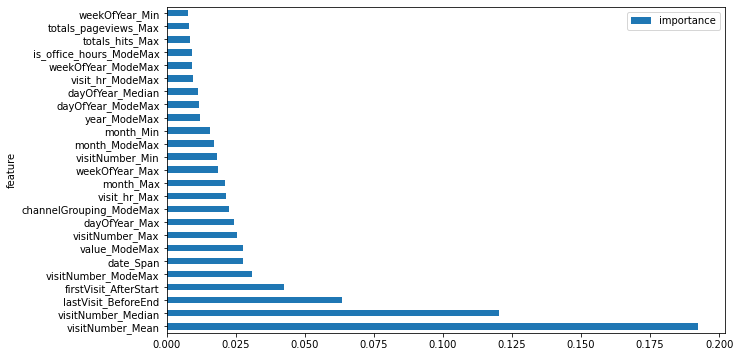

In [ ]:
cls_imp = pd.DataFrame({"feature":trainX_cls.columns,
                        "importance":[val[0] for val in cls_model.feature_importances_.reshape(-1,1)]}).sort_values(by="importance",ascending=False)[:25]

cls_imp.plot(kind="barh", x="feature", y="importance", figsize=(10,6))

In [ ]:
%%time
reg_model.fit(trainX_reg,trainY_reg)

CPU times: user 290 ms, sys: 21 ms, total: 311 ms
Wall time: 307 ms


XGBRegressor(learning_rate=0.001, max_depth=4, n_jobs=-1,
             objective='reg:squarederror', predictor='gpu_predictor',
             tree_method='gpu_hist')

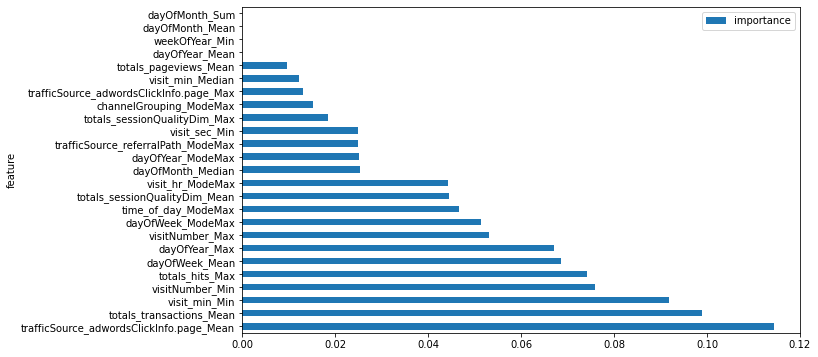

In [ ]:
reg_imp = pd.DataFrame({"feature":trainX_reg.columns,
                        "importance":[val[0] for val in reg_model.feature_importances_.reshape(-1,1)]}).sort_values(by="importance",ascending=False)[:25]

reg_imp.plot(kind="barh", x="feature", y="importance", figsize=(10,6))

In [ ]:
# saving the model:-
filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files_2/models_4.1/gbdt_cls_model.sav'
pickle.dump(cls_model, open(filename, 'wb'))

filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files_2/models_4.1/gbdt_reg_model.sav'
pickle.dump(reg_model, open(filename, 'wb'))

### <font color='#088da5'>Prediction using the Best Hyper-parameter Tuned Models</font>

In [ ]:
cls_pred = cls_model.predict_proba(testX)[:,1]
print(cls_pred)
reg_pred = reg_model.predict(testX)
print(reg_pred)

[0.00168385 0.00049391 0.00049021 ... 0.00134474 0.00048217 0.0019485 ]
[0.48040003 0.48040003 0.48040003 ... 0.48040003 0.48040003 0.48040003]


In [ ]:
testY_pred = cls_pred*reg_pred
print(testY_pred.shape)
print(testY_pred)

(296530,)
[0.00080892 0.00023727 0.0002355  ... 0.00064601 0.00023163 0.00093606]


In [ ]:
subm = pd.DataFrame(data={"fullVisitorId":test["fullVisitorId"],"PredictedLogRevenue":testY_pred})

In [ ]:
print("Negative predicted revenue check:",set(subm['PredictedLogRevenue']<0))

Negative predicted revenue check: {False}


In [ ]:
subm.to_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files_2/models_4.1/submit_GBDT1.csv",index=False)
subm.head()

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.000809
1,0000039738481224681,0.000237
2,0000073585230191399,0.000235
3,0000087588448856385,0.000206
4,0000149787903119437,0.000215


## 4.2. <font color='#8fce00'>GBDT-2: XGBClassifier + XGBRegressor</font>

RandomizedSearchCV Hyper-parameter tuning:-
* cls - max_depth, n_estimators, learning_rate, subsample
* reg - max_depth, n_estimators, learning_rate, subsample

tree_method = "gpu_hist"<br>
n_iter = 20

### <font color='#088da5'>Defining: Classification & Regression Models for RandomizedSearchCV</font>

In [ ]:
cls_gbdt = XGBClassifier(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor")
params_cls = {'max_depth': [1,2,3,4,5,10,15,20],
              'n_estimators':[50,100,150,200,250,300,350,400,450,500,1000],
              'learning_rate':[0.0001,0.001,0.01,0.05,0.1,0.5,1,10],
              'subsample':[0.2,0.4,0.5,0.6,0.8]}

reg_gbdt = XGBRegressor(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor", objective="reg:squarederror")
params_reg = {'max_depth': [1,2,3,4,5,10,15,20],
              'n_estimators':[50,100,150,200,250,300,350,400,450,500,1000],
              'learning_rate':[0.0001,0.001,0.01,0.05,0.1,0.5,1,10],
              'subsample':[0.2,0.4,0.5,0.6,0.8]}

In [ ]:
cls_rndm = get_CrossValidators(validator_type="R",model_type="cls",estimator_val=cls_gbdt,params=params_cls,n_it=20)
reg_rndm = get_CrossValidators(validator_type="R",model_type="reg",estimator_val=reg_gbdt,params=params_reg,n_it=20)

### <font color='#088da5'>Fitting the RandomizedSearchCV</font>

In [ ]:
%%time
cls_rndm.fit(trainX_cls,trainY_cls)

CPU times: user 40min 39s, sys: 24.1 s, total: 41min 3s
Wall time: 40min 53s


RandomizedSearchCV(cv=[(array([     0,      1,      2, ..., 128872, 128873, 128874]),
                        array([128875, 128876, 128877, ..., 257742, 257743, 257744])),
                       (array([     0,      1,      2, ..., 257742, 257743, 257744]),
                        array([257745, 257746, 257747, ..., 386612, 386613, 386614])),
                       (array([     0,      1,      2, ..., 386612, 386613, 386614]),
                        array([386615, 386616, 386617, ..., 515482, 515483, 515484])),
                       (array([     0,      1,      2, ..., 515482, 515483, 5154...
                        array([1288705, 1288706, 1288707, ..., 1417572, 1417573, 1417574]))],
                   estimator=XGBClassifier(n_jobs=-1, predictor='gpu_predictor',
                                           tree_method='gpu_hist'),
                   n_iter=20,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                             

In [ ]:
%%time
reg_rndm.fit(trainX_reg,trainY_reg)

CPU times: user 7min 35s, sys: 4.93 s, total: 7min 40s
Wall time: 7min 37s


RandomizedSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 1...
                                          objective='reg:squarederror',
                                          predictor='gpu_predictor',
                                          tree_method='gpu_hist'),
                   n_iter=20,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                        

### <font color='#088da5'>Best Parameters obtained via RandomizedSearchCV</font>

In [ ]:
cls_best,reg_best = get_BestScoreParams(cls_rndm,reg_rndm)

For classifier:-
Best params--> {'subsample': 0.4, 'n_estimators': 400, 'max_depth': 2, 'learning_rate': 0.05}
Best score--> -0.02979580464005674

For regressor:-
Best params--> {'subsample': 0.4, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.001}
Best score--> -2.4478192207650746


### <font color='#088da5'>Training the Classification & Regression models using the Best Parameters obtained</font>

In [ ]:
cls_model = XGBClassifier(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor",
                          n_estimators=cls_best['n_estimators'], max_depth=cls_best['max_depth'], learning_rate=cls_best['learning_rate'],
                          subsample=cls_best['subsample'])

reg_model = XGBRegressor(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor", objective="reg:squarederror",
                         n_estimators=reg_best['n_estimators'], max_depth=reg_best['max_depth'], learning_rate=reg_best['learning_rate'],
                         subsample=reg_best['subsample'])

In [ ]:
%%time
cls_model.fit(trainX_cls,trainY_cls)

CPU times: user 15.5 s, sys: 95.9 ms, total: 15.6 s
Wall time: 15.6 s


XGBClassifier(learning_rate=0.05, max_depth=2, n_estimators=400, n_jobs=-1,
              predictor='gpu_predictor', subsample=0.4, tree_method='gpu_hist')

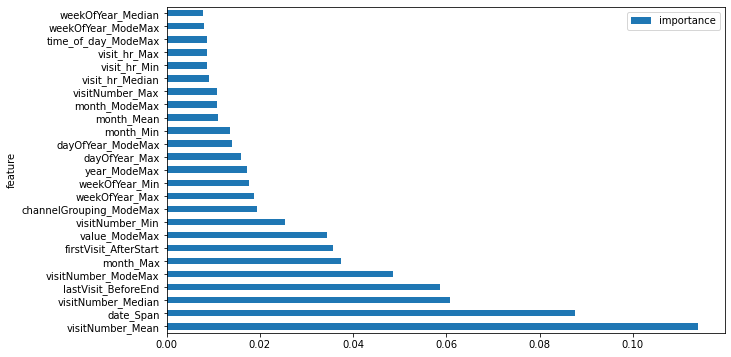

In [ ]:
cls_imp = pd.DataFrame({"feature":trainX_cls.columns,
                        "importance":[val[0] for val in cls_model.feature_importances_.reshape(-1,1)]}).sort_values(by="importance",ascending=False)[:25]

cls_imp.plot(kind="barh", x="feature", y="importance", figsize=(10,6))

In [ ]:
%%time
reg_model.fit(trainX_reg,trainY_reg)

CPU times: user 667 ms, sys: 23 ms, total: 690 ms
Wall time: 684 ms


XGBRegressor(learning_rate=0.001, max_depth=10, n_jobs=-1,
             objective='reg:squarederror', predictor='gpu_predictor',
             subsample=0.4, tree_method='gpu_hist')

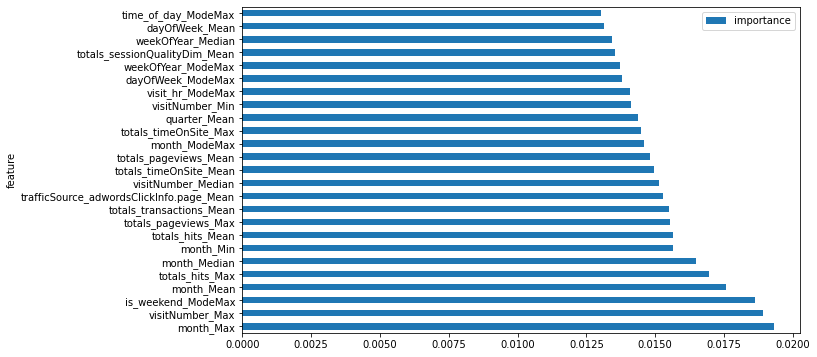

In [ ]:
reg_imp = pd.DataFrame({"feature":trainX_reg.columns,
                        "importance":[val[0] for val in reg_model.feature_importances_.reshape(-1,1)]}).sort_values(by="importance",ascending=False)[:25]

reg_imp.plot(kind="barh", x="feature", y="importance", figsize=(10,6))

In [ ]:
# saving the model:-
filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files_2/models_4.2/gbdt_cls_model.sav'
pickle.dump(cls_model, open(filename, 'wb'))

filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files_2/models_4.2/gbdt_reg_model.sav'
pickle.dump(reg_model, open(filename, 'wb'))

### <font color='#088da5'>Prediction using the Best Hyper-parameter Tuned Models</font>

In [ ]:
cls_pred = cls_model.predict_proba(testX)[:,1]
print(cls_pred)
reg_pred = reg_model.predict(testX)
print(reg_pred)

[0.00256629 0.0017234  0.00138405 ... 0.00250927 0.00155314 0.00313442]
[0.46405542 0.46334088 0.53964275 ... 0.47427633 0.4948208  0.4629165 ]


In [ ]:
testY_pred = cls_pred*reg_pred
print(testY_pred.shape)
print(testY_pred)

(296530,)
[0.0011909  0.00079852 0.00074689 ... 0.00119009 0.00076852 0.00145098]


In [ ]:
subm = pd.DataFrame(data={"fullVisitorId":test["fullVisitorId"],"PredictedLogRevenue":testY_pred})

In [ ]:
print("Negative predicted revenue check:",set(subm['PredictedLogRevenue']<0))

Negative predicted revenue check: {False}


In [ ]:
subm.to_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files_2/models_4.2/submit_GBDT2.csv",index=False)
subm.head()

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.001191
1,0000039738481224681,0.000799
2,0000073585230191399,0.000747
3,0000087588448856385,0.000455
4,0000149787903119437,0.000459


## 4.3. <font color='#8fce00'>GBDT-3: XGBClassifier + XGBRegressor</font>

RandomizedSearchCV Hyper-parameter tuning:-
* cls - max_depth, n_estimators, learning_rate, subsample, colsample_bytree, colsample_bylevel, colsample_bynode
* reg - max_depth, n_estimators, learning_rate, subsample, colsample_bytree, colsample_bylevel, colsample_bynode

tree_method = "gpu_hist"<br>
n_iter = 10 (default)

### <font color='#088da5'>Defining: Classification & Regression Models for RandomizedSearchCV</font>

In [ ]:
cls_gbdt = XGBClassifier(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor")
params_cls = {'max_depth': [1,2,3,4,5,10,15,20],
              'n_estimators':[50,100,150,200,250,300,350,400,450,500,1000],
              'learning_rate':[0.0001,0.001,0.01,0.05,0.1,0.5,1,10],
              'subsample':[0.2,0.4,0.5,0.6,0.8],
              'colsample_bytree':[0.2,0.4,0.5,0.6,0.8],
              'colsample_bylevel':[0.2,0.4,0.5,0.6,0.8],
              'colsample_bynode':[0.2,0.4,0.5,0.6,0.8]}

reg_gbdt = XGBRegressor(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor", objective="reg:squarederror")
params_reg = {'max_depth': [1,2,3,4,5,10,15,20],
              'n_estimators':[50,100,150,200,250,300,350,400,450,500,1000],
              'learning_rate':[0.0001,0.001,0.01,0.05,0.1,0.5,1,10],
              'subsample':[0.2,0.4,0.5,0.6,0.8],
              'colsample_bytree':[0.2,0.4,0.5,0.6,0.8],
              'colsample_bylevel':[0.2,0.4,0.5,0.6,0.8],
              'colsample_bynode':[0.2,0.4,0.5,0.6,0.8]}

In [ ]:
cls_rndm = get_CrossValidators(validator_type="R",model_type="cls",estimator_val=cls_gbdt,params=params_cls,n_it=10)
reg_rndm = get_CrossValidators(validator_type="R",model_type="reg",estimator_val=reg_gbdt,params=params_reg,n_it=10)

### <font color='#088da5'>Fitting the RandomizedSearchCV</font>

In [ ]:
%%time
cls_rndm.fit(trainX_cls,trainY_cls)

CPU times: user 22min 57s, sys: 15.3 s, total: 23min 12s
Wall time: 23min 6s


RandomizedSearchCV(cv=[(array([     0,      1,      2, ..., 128872, 128873, 128874]),
                        array([128875, 128876, 128877, ..., 257742, 257743, 257744])),
                       (array([     0,      1,      2, ..., 257742, 257743, 257744]),
                        array([257745, 257746, 257747, ..., 386612, 386613, 386614])),
                       (array([     0,      1,      2, ..., 386612, 386613, 386614]),
                        array([386615, 386616, 386617, ..., 515482, 515483, 515484])),
                       (array([     0,      1,      2, ..., 515482, 515483, 5154...
                   param_distributions={'colsample_bylevel': [0.2, 0.4, 0.5,
                                                              0.6, 0.8],
                                        'colsample_bynode': [0.2, 0.4, 0.5, 0.6,
                                                             0.8],
                                        'colsample_bytree': [0.2, 0.4, 0.5, 0.6,
                  

In [ ]:
%%time
reg_rndm.fit(trainX_reg,trainY_reg)

CPU times: user 2min 52s, sys: 3.57 s, total: 2min 56s
Wall time: 2min 55s


RandomizedSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 1...
                   param_distributions={'colsample_bylevel': [0.2, 0.4, 0.5,
                                                              0.6, 0.8],
                                        'colsample_bynode': [0.2, 0.4, 0.5, 0.6,
                                                             0.8],
                                        'colsample_bytree': [0.2, 0.4, 0.5,

### <font color='#088da5'>Best Parameters obtained via RandomizedSearchCV</font>

In [ ]:
cls_best,reg_best = get_BestScoreParams(cls_rndm,reg_rndm)

For classifier:-
Best params--> {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.5, 'colsample_bytree': 0.4, 'colsample_bynode': 0.5, 'colsample_bylevel': 0.4}
Best score--> -0.031051845440713592

For regressor:-
Best params--> {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.001, 'colsample_bytree': 0.4, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.5}
Best score--> -2.447884871324224


### <font color='#088da5'>Training the Classification & Regression models using the Best Parameters obtained</font>

In [ ]:
cls_model = XGBClassifier(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor",
                          n_estimators=cls_best['n_estimators'], max_depth=cls_best['max_depth'], learning_rate=cls_best['learning_rate'],
                          subsample=cls_best['subsample'], colsample_bytree=cls_best['colsample_bytree'],
                          colsample_bylevel=cls_best['colsample_bylevel'], colsample_bynode=cls_best['colsample_bynode'])

reg_model = XGBRegressor(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor", objective="reg:squarederror",
                         n_estimators=reg_best['n_estimators'], max_depth=reg_best['max_depth'], learning_rate=reg_best['learning_rate'],
                         subsample=reg_best['subsample'], colsample_bytree=reg_best['colsample_bytree'],
                         colsample_bylevel=reg_best['colsample_bylevel'], colsample_bynode=reg_best['colsample_bynode'])

In [ ]:
%%time
cls_model.fit(trainX_cls,trainY_cls)

CPU times: user 18.8 s, sys: 91 ms, total: 18.9 s
Wall time: 18.8 s


XGBClassifier(colsample_bylevel=0.4, colsample_bynode=0.5, colsample_bytree=0.4,
              learning_rate=0.5, max_depth=2, n_estimators=500, n_jobs=-1,
              predictor='gpu_predictor', subsample=0.8, tree_method='gpu_hist')

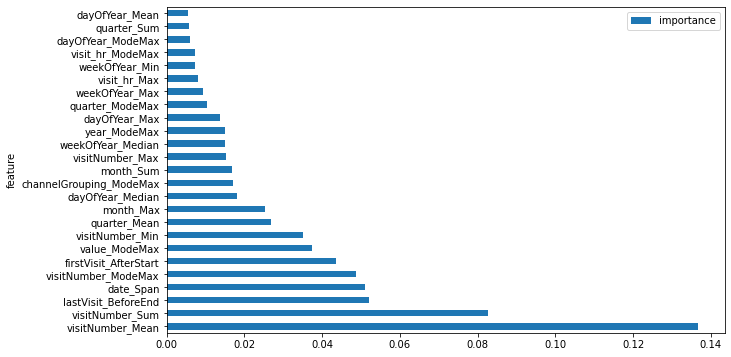

In [ ]:
cls_imp = pd.DataFrame({"feature":trainX_cls.columns,
                        "importance":[val[0] for val in cls_model.feature_importances_.reshape(-1,1)]}).sort_values(by="importance",ascending=False)[:25]

cls_imp.plot(kind="barh", x="feature", y="importance", figsize=(10,6))

In [ ]:
%%time
reg_model.fit(trainX_reg,trainY_reg)

CPU times: user 2.72 s, sys: 61 ms, total: 2.78 s
Wall time: 2.77 s


XGBRegressor(colsample_bylevel=0.5, colsample_bynode=0.6, colsample_bytree=0.4,
             learning_rate=0.001, max_depth=15, n_jobs=-1,
             objective='reg:squarederror', predictor='gpu_predictor',
             subsample=0.8, tree_method='gpu_hist')

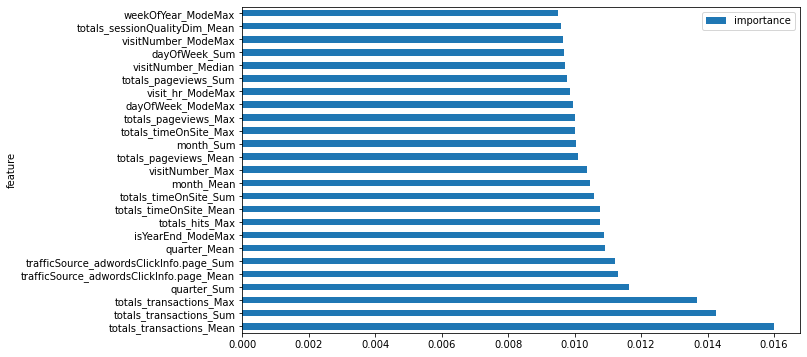

In [ ]:
reg_imp = pd.DataFrame({"feature":trainX_reg.columns,
                        "importance":[val[0] for val in reg_model.feature_importances_.reshape(-1,1)]}).sort_values(by="importance",ascending=False)[:25]

reg_imp.plot(kind="barh", x="feature", y="importance", figsize=(10,6))

In [ ]:
# saving the model:-
filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files_2/models_4.3/gbdt_cls_model.sav'
pickle.dump(cls_model, open(filename, 'wb'))

filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files_2/models_4.3/gbdt_reg_model.sav'
pickle.dump(reg_model, open(filename, 'wb'))

### <font color='#088da5'>Prediction using the Best Hyper-parameter Tuned Models</font>

In [ ]:
cls_pred = cls_model.predict_proba(testX)[:,1]
print(cls_pred)
reg_pred = reg_model.predict(testX)
print(reg_pred)

[0.00117801 0.00182516 0.00115517 ... 0.0007778  0.00076662 0.00113591]
[0.45746627 0.45665666 0.5110099  ... 0.46410707 0.47407982 0.45622015]


In [ ]:
testY_pred = cls_pred*reg_pred
print(testY_pred.shape)
print(testY_pred)

(296530,)
[0.0005389  0.00083347 0.0005903  ... 0.00036098 0.00036344 0.00051822]


In [ ]:
subm = pd.DataFrame(data={"fullVisitorId":test["fullVisitorId"],"PredictedLogRevenue":testY_pred})

In [ ]:
print("Negative predicted revenue check:",set(subm['PredictedLogRevenue']<0))

Negative predicted revenue check: {False}


In [ ]:
subm.to_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files_2/models_4.3/submit_GBDT3.csv",index=False)
subm.head()

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.000539
1,0000039738481224681,0.000833
2,0000073585230191399,0.000590
3,0000087588448856385,0.000252
4,0000149787903119437,0.000541


## 4.4. <font color='#8fce00'>GBDT-4: XGBClassifier + XGBRegressor</font>

RandomizedSearchCV Hyper-parameter tuning:-
* cls - max_depth, n_estimators, learning_rate, subsample, colsample_bytree, colsample_bylevel, colsample_bynode
* reg - max_depth, n_estimators, learning_rate, subsample, colsample_bytree, colsample_bylevel, colsample_bynode

tree_method = "gpu_hist"<br>
n_iter = 30

### <font color='#088da5'>Defining: Classification & Regression Models for RandomizedSearchCV</font>

In [ ]:
cls_gbdt = XGBClassifier(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor")
params_cls = {'max_depth': [1,2,3,4,5,10,15,20],
              'n_estimators':[50,100,150,200,250,300,350,400,450,500,1000],
              'learning_rate':[0.0001,0.001,0.01,0.05,0.1,0.5,1,10],
              'subsample':[0.2,0.4,0.5,0.6,0.8],
              'colsample_bytree':[0.2,0.4,0.5,0.6,0.8],
              'colsample_bylevel':[0.2,0.4,0.5,0.6,0.8],
              'colsample_bynode':[0.2,0.4,0.5,0.6,0.8]}

reg_gbdt = XGBRegressor(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor", objective="reg:squarederror")
params_reg = {'max_depth': [1,2,3,4,5,10,15,20],
              'n_estimators':[50,100,150,200,250,300,350,400,450,500,1000],
              'learning_rate':[0.0001,0.001,0.01,0.05,0.1,0.5,1,10],
              'subsample':[0.2,0.4,0.5,0.6,0.8],
              'colsample_bytree':[0.2,0.4,0.5,0.6,0.8],
              'colsample_bylevel':[0.2,0.4,0.5,0.6,0.8],
              'colsample_bynode':[0.2,0.4,0.5,0.6,0.8]}

In [ ]:
cls_rndm = get_CrossValidators(validator_type="R",model_type="cls",estimator_val=cls_gbdt,params=params_cls,n_it=30)
reg_rndm = get_CrossValidators(validator_type="R",model_type="reg",estimator_val=reg_gbdt,params=params_reg,n_it=30)

### <font color='#088da5'>Fitting the RandomizedSearchCV</font>

In [ ]:
# modified the RandomSearchCV definition to verbose=20 for this model

In [ ]:
%%time
cls_rndm.fit(trainX_cls,trainY_cls)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV 1/10; 1/30] START colsample_bylevel=0.2, colsample_bynode=0.5, colsample_bytree=0.2, learning_rate=0.05, max_depth=1, n_estimators=250, subsample=0.4
[CV 1/10; 1/30] END colsample_bylevel=0.2, colsample_bynode=0.5, colsample_bytree=0.2, learning_rate=0.05, max_depth=1, n_estimators=250, subsample=0.4;, score=(train=-0.024, test=-0.026) total time=   1.8s
[CV 2/10; 1/30] START colsample_bylevel=0.2, colsample_bynode=0.5, colsample_bytree=0.2, learning_rate=0.05, max_depth=1, n_estimators=250, subsample=0.4
[CV 2/10; 1/30] END colsample_bylevel=0.2, colsample_bynode=0.5, colsample_bytree=0.2, learning_rate=0.05, max_depth=1, n_estimators=250, subsample=0.4;, score=(train=-0.025, test=-0.027) total time=   2.3s
[CV 3/10; 1/30] START colsample_bylevel=0.2, colsample_bynode=0.5, colsample_bytree=0.2, learning_rate=0.05, max_depth=1, n_estimators=250, subsample=0.4
[CV 3/10; 1/30] END colsample_bylevel=0.2, colsample_bynode=0

RandomizedSearchCV(cv=[(array([     0,      1,      2, ..., 128872, 128873, 128874]),
                        array([128875, 128876, 128877, ..., 257742, 257743, 257744])),
                       (array([     0,      1,      2, ..., 257742, 257743, 257744]),
                        array([257745, 257746, 257747, ..., 386612, 386613, 386614])),
                       (array([     0,      1,      2, ..., 386612, 386613, 386614]),
                        array([386615, 386616, 386617, ..., 515482, 515483, 515484])),
                       (array([     0,      1,      2, ..., 515482, 515483, 5154...
                   param_distributions={'colsample_bylevel': [0.2, 0.4, 0.5,
                                                              0.6, 0.8],
                                        'colsample_bynode': [0.2, 0.4, 0.5, 0.6,
                                                             0.8],
                                        'colsample_bytree': [0.2, 0.4, 0.5, 0.6,
                  

In [ ]:
%%time
reg_rndm.fit(trainX_reg,trainY_reg)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV 1/10; 1/30] START colsample_bylevel=0.2, colsample_bynode=0.2, colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=250, subsample=0.5
[CV 1/10; 1/30] END colsample_bylevel=0.2, colsample_bynode=0.2, colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=250, subsample=0.5;, score=(train=-2.187, test=-2.531) total time=   0.4s
[CV 2/10; 1/30] START colsample_bylevel=0.2, colsample_bynode=0.2, colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=250, subsample=0.5
[CV 2/10; 1/30] END colsample_bylevel=0.2, colsample_bynode=0.2, colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=250, subsample=0.5;, score=(train=-2.349, test=-1.903) total time=   0.5s
[CV 3/10; 1/30] START colsample_bylevel=0.2, colsample_bynode=0.2, colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=250, subsample=0.5
[CV 3/10; 1/30] END colsample_bylevel=0.2, colsample_bynode=0

RandomizedSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 1...
                   param_distributions={'colsample_bylevel': [0.2, 0.4, 0.5,
                                                              0.6, 0.8],
                                        'colsample_bynode': [0.2, 0.4, 0.5, 0.6,
                                                             0.8],
                                        'colsample_bytree': [0.2, 0.4, 0.5,

### <font color='#088da5'>Best Parameters obtained via RandomizedSearchCV</font>

In [ ]:
cls_best,reg_best = get_BestScoreParams(cls_rndm,reg_rndm)

For classifier:-
Best params--> {'subsample': 0.5, 'n_estimators': 350, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.5, 'colsample_bynode': 0.5, 'colsample_bylevel': 0.8}
Best score--> -0.029765301364480495

For regressor:-
Best params--> {'subsample': 0.5, 'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'colsample_bynode': 0.2, 'colsample_bylevel': 0.2}
Best score--> -2.4439596809055204


### <font color='#088da5'>Training the Classification & Regression models using the Best Parameters obtained</font>

In [ ]:
cls_model = XGBClassifier(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor",
                          n_estimators=cls_best['n_estimators'], max_depth=cls_best['max_depth'], learning_rate=cls_best['learning_rate'],
                          subsample=cls_best['subsample'], colsample_bytree=cls_best['colsample_bytree'],
                          colsample_bylevel=cls_best['colsample_bylevel'], colsample_bynode=cls_best['colsample_bynode'])

reg_model = XGBRegressor(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor", objective="reg:squarederror",
                         n_estimators=reg_best['n_estimators'], max_depth=reg_best['max_depth'], learning_rate=reg_best['learning_rate'],
                         subsample=reg_best['subsample'], colsample_bytree=reg_best['colsample_bytree'],
                         colsample_bylevel=reg_best['colsample_bylevel'], colsample_bynode=reg_best['colsample_bynode'])

In [ ]:
%%time
cls_model.fit(trainX_cls,trainY_cls)

CPU times: user 15.8 s, sys: 91 ms, total: 15.9 s
Wall time: 15.9 s


XGBClassifier(colsample_bylevel=0.8, colsample_bynode=0.5, colsample_bytree=0.5,
              learning_rate=0.05, n_estimators=350, n_jobs=-1,
              predictor='gpu_predictor', subsample=0.5, tree_method='gpu_hist')

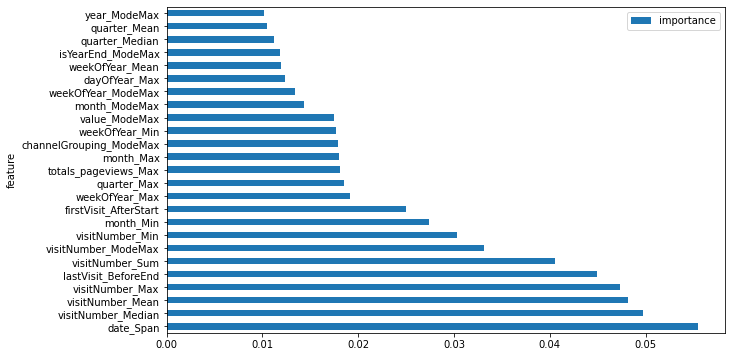

In [ ]:
cls_imp = pd.DataFrame({"feature":trainX_cls.columns,
                        "importance":[val[0] for val in cls_model.feature_importances_.reshape(-1,1)]}).sort_values(by="importance",ascending=False)[:25]

cls_imp.plot(kind="barh", x="feature", y="importance", figsize=(10,6))

In [ ]:
%%time
reg_model.fit(trainX_reg,trainY_reg)

CPU times: user 571 ms, sys: 22 ms, total: 593 ms
Wall time: 588 ms


XGBRegressor(colsample_bylevel=0.2, colsample_bynode=0.2, colsample_bytree=0.6,
             learning_rate=0.01, n_estimators=250, n_jobs=-1,
             objective='reg:squarederror', predictor='gpu_predictor',
             subsample=0.5, tree_method='gpu_hist')

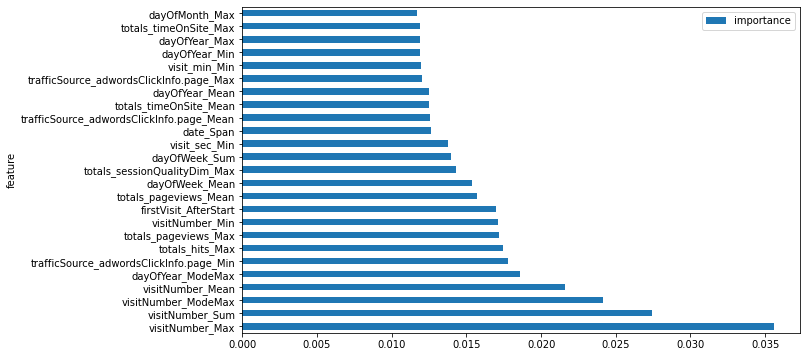

In [ ]:
reg_imp = pd.DataFrame({"feature":trainX_reg.columns,
                        "importance":[val[0] for val in reg_model.feature_importances_.reshape(-1,1)]}).sort_values(by="importance",ascending=False)[:25]

reg_imp.plot(kind="barh", x="feature", y="importance", figsize=(10,6))

In [ ]:
# saving the model:-
filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files_2/models_4.4/gbdt_cls_model.sav'
pickle.dump(cls_model, open(filename, 'wb'))

filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files_2/models_4.4/gbdt_reg_model.sav'
pickle.dump(reg_model, open(filename, 'wb'))

### <font color='#088da5'>Prediction using the Best Hyper-parameter Tuned Models</font>

In [ ]:
cls_pred = cls_model.predict_proba(testX)[:,1]
print(cls_pred)
reg_pred = reg_model.predict(testX)
print(reg_pred)

[0.0023401  0.00261513 0.00169111 ... 0.00216019 0.00187022 0.00261393]
[0.29911047 0.27791205 0.35635027 ... 0.4074967  0.28345293 0.31341624]


In [ ]:
testY_pred = cls_pred*reg_pred
print(testY_pred.shape)
print(testY_pred)

(296530,)
[0.00069995 0.00072678 0.00060263 ... 0.00088027 0.00053012 0.00081925]


In [ ]:
subm = pd.DataFrame(data={"fullVisitorId":test["fullVisitorId"],"PredictedLogRevenue":testY_pred})

In [ ]:
print("Negative predicted revenue check:",set(subm['PredictedLogRevenue']<0))

Negative predicted revenue check: {False}


In [ ]:
subm.to_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files_2/models_4.4/submit_GBDT4.csv",index=False)
subm.head()

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.000700
1,0000039738481224681,0.000727
2,0000073585230191399,0.000603
3,0000087588448856385,0.000294
4,0000149787903119437,0.000300


## 4.5. <font color='#8fce00'>GBDT-5: LGBMClassifier + LGBMRegressor</font>

RandomizedSearchCV Hyper-parameter tuning:-
* cls - num_leaves, max_depth, n_estimators, learning_rate, subsample, colsample_bytree, min_child_samples, reg_alpha, reg_lambda
* reg - num_leaves, max_depth, n_estimators, learning_rate, subsample, colsample_bytree, min_child_samples, reg_alpha, reg_lambda

### <font color='#088da5'>Defining: Classification & Regression Models for RandomizedSearchCV</font>

In [ ]:
cls_gbdt = LGBMClassifier(n_jobs=-1, boosting_type="gbdt", objective="binary", importance_type="gain")
params_cls = {'num_leaves':[2,5,10,15,20,25,31],
              'max_depth':[1,2,3,4,5,10,15,20],
              'learning_rate':[0.0001,0.001,0.01,0.05,0.1,0.5,1,10],
              'n_estimators':[50,100,150,200,250,300,350,400,450,500,1000],
              'min_child_samples':[1,2,4,6,8,10,15,20],
              'subsample':[0.2,0.5,0.6,0.7,0.8,0.9,1.0],
              'colsample_bytree':[0.2,0.4,0.5,0.6,0.8,0.9,1.0],
              'reg_alpha':[0,1],
              'reg_lambda':[0,1]}

reg_gbdt = LGBMRegressor(n_jobs=-1, boosting_type="gbdt", objective="regression", importance_type="gain")
params_reg = {'num_leaves':[2,5,10,15,20,25,31],
              'max_depth':[1,2,3,4,5,10,15,20],
              'learning_rate':[0.0001,0.001,0.01,0.05,0.1,0.5,1,10],
              'n_estimators':[50,100,150,200,250,300,350,400,450,500,1000],
              'min_child_samples':[1,2,4,6,8,10,15,20],
              'subsample':[0.2,0.5,0.6,0.7,0.8,0.9,1.0],
              'colsample_bytree':[0.2,0.4,0.5,0.6,0.8,0.9,1.0],
              'reg_alpha':[0,1],
              'reg_lambda':[0,1]}

In [ ]:
cls_rndm = get_CrossValidators(validator_type="R",model_type="cls",estimator_val=cls_gbdt,params=params_cls)
reg_rndm = get_CrossValidators(validator_type="R",model_type="reg",estimator_val=reg_gbdt,params=params_reg)

### <font color='#088da5'>Fitting the RandomizedSearchCV</font>

In [ ]:
# modified the RandomSearchCV definition to verbose=10 for this model

In [ ]:
%%time
cls_rndm.fit(trainX_cls,trainY_cls)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START colsample_bytree=0.2, learning_rate=10, max_depth=1, min_child_samples=6, n_estimators=400, num_leaves=20, reg_alpha=0, reg_lambda=1, subsample=0.8
[CV 1/10; 1/10] END colsample_bytree=0.2, learning_rate=10, max_depth=1, min_child_samples=6, n_estimators=400, num_leaves=20, reg_alpha=0, reg_lambda=1, subsample=0.8;, score=(train=-33.334, test=-33.281) total time=   3.6s
[CV 2/10; 1/10] START colsample_bytree=0.2, learning_rate=10, max_depth=1, min_child_samples=6, n_estimators=400, num_leaves=20, reg_alpha=0, reg_lambda=1, subsample=0.8
[CV 2/10; 1/10] END colsample_bytree=0.2, learning_rate=10, max_depth=1, min_child_samples=6, n_estimators=400, num_leaves=20, reg_alpha=0, reg_lambda=1, subsample=0.8;, score=(train=-33.859, test=-33.859) total time=   6.3s
[CV 3/10; 1/10] START colsample_bytree=0.2, learning_rate=10, max_depth=1, min_child_samples=6, n_estimators=400, num_leaves=20, reg_alpha=0, reg_l

RandomizedSearchCV(cv=[(array([     0,      1,      2, ..., 128872, 128873, 128874]),
                        array([128875, 128876, 128877, ..., 257742, 257743, 257744])),
                       (array([     0,      1,      2, ..., 257742, 257743, 257744]),
                        array([257745, 257746, 257747, ..., 386612, 386613, 386614])),
                       (array([     0,      1,      2, ..., 386612, 386613, 386614]),
                        array([386615, 386616, 386617, ..., 515482, 515483, 515484])),
                       (array([     0,      1,      2, ..., 515482, 515483, 5154...
                                        'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.05, 0.1, 0.5, 1,
                                                          10],
                                        'max_depth': [1, 2, 3, 4, 5, 10, 15,
                                                      20],
                                        'm

In [ ]:
%%time
reg_rndm.fit(trainX_reg,trainY_reg)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START colsample_bytree=0.8, learning_rate=10, max_depth=5, min_child_samples=1, n_estimators=50, num_leaves=25, reg_alpha=0, reg_lambda=1, subsample=0.5
[CV 1/10; 1/10] END colsample_bytree=0.8, learning_rate=10, max_depth=5, min_child_samples=1, n_estimators=50, num_leaves=25, reg_alpha=0, reg_lambda=1, subsample=0.5;, score=(train=-288840770290039258860715325190251216896.000, test=-289441154421130332124353439474816909312.000) total time=   0.1s
[CV 2/10; 1/10] START colsample_bytree=0.8, learning_rate=10, max_depth=5, min_child_samples=1, n_estimators=50, num_leaves=25, reg_alpha=0, reg_lambda=1, subsample=0.5
[CV 2/10; 1/10] END colsample_bytree=0.8, learning_rate=10, max_depth=5, min_child_samples=1, n_estimators=50, num_leaves=25, reg_alpha=0, reg_lambda=1, subsample=0.5;, score=(train=-180397590856961269391999499353374851072.000, test=-177129054888540789291154420814902722560.000) total time=   0.1s
[CV

RandomizedSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 1...
                                        'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.05, 0.1, 0.5, 1,
                                                          10],
                                        'max_depth': [1, 2, 3, 4, 5, 10, 15,
                                                      20],
                  

### <font color='#088da5'>Best Parameters obtained via RandomizedSearchCV</font>

In [ ]:
cls_best,reg_best = get_BestScoreParams(cls_rndm,reg_rndm)

For classifier:-
Best params--> {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0, 'num_leaves': 5, 'n_estimators': 400, 'min_child_samples': 10, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Best score--> -0.029773061707117777

For regressor:-
Best params--> {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'num_leaves': 25, 'n_estimators': 250, 'min_child_samples': 20, 'max_depth': 3, 'learning_rate': 0.001, 'colsample_bytree': 0.9}
Best score--> -2.4429192981147336


### <font color='#088da5'>Training the Classification & Regression models using the Best Parameters obtained</font>

In [ ]:
cls_model = LGBMClassifier(n_jobs=-1, boosting_type="gbdt", objective="binary", importance_type="gain",
                           num_leaves=cls_best['num_leaves'], max_depth=cls_best['max_depth'], learning_rate=cls_best['learning_rate'],
                           n_estimators=cls_best['n_estimators'], min_child_samples=cls_best['min_child_samples'], subsample=cls_best['subsample'],
                           colsample_bytree=cls_best['colsample_bytree'], reg_alpha=cls_best['reg_alpha'], reg_lambda=cls_best['reg_lambda'])

reg_model = LGBMRegressor(n_jobs=-1, boosting_type="gbdt", objective="regression", importance_type="gain",
                          num_leaves=reg_best['num_leaves'], max_depth=reg_best['max_depth'], learning_rate=reg_best['learning_rate'],
                          n_estimators=reg_best['n_estimators'], min_child_samples=reg_best['min_child_samples'], subsample=reg_best['subsample'],
                          colsample_bytree=reg_best['colsample_bytree'], reg_alpha=reg_best['reg_alpha'], reg_lambda=reg_best['reg_lambda'])

In [ ]:
%%time
cls_model.fit(trainX_cls,trainY_cls)

CPU times: user 5min 29s, sys: 362 ms, total: 5min 29s
Wall time: 1min 26s


LGBMClassifier(colsample_bytree=0.9, importance_type='gain', max_depth=15,
               min_child_samples=10, n_estimators=400, num_leaves=5,
               objective='binary', reg_alpha=0, reg_lambda=1, subsample=0.6)

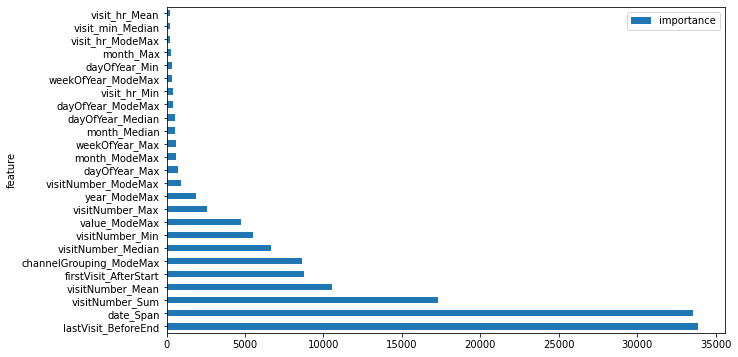

In [ ]:
cls_imp = pd.DataFrame({"feature":trainX_cls.columns,
                        "importance":[val[0] for val in cls_model.feature_importances_.reshape(-1,1)]}).sort_values(by="importance",ascending=False)[:25]

cls_imp.plot(kind="barh", x="feature", y="importance", figsize=(10,6))

In [ ]:
%%time
reg_model.fit(trainX_reg,trainY_reg)

CPU times: user 1.66 s, sys: 12 ms, total: 1.67 s
Wall time: 465 ms


LGBMRegressor(colsample_bytree=0.9, importance_type='gain', learning_rate=0.001,
              max_depth=3, n_estimators=250, num_leaves=25,
              objective='regression', reg_alpha=0, reg_lambda=1, subsample=0.8)

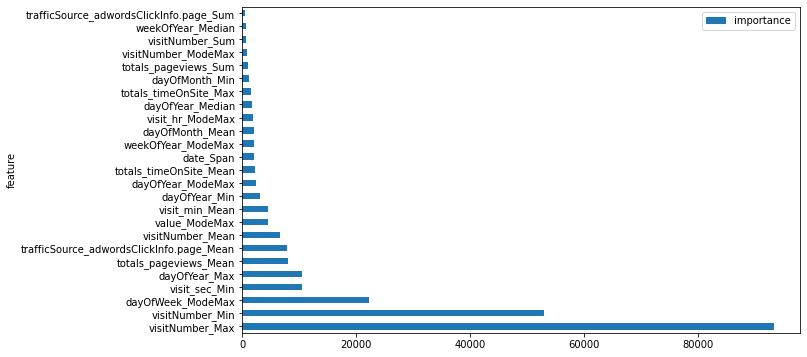

In [ ]:
reg_imp = pd.DataFrame({"feature":trainX_reg.columns,
                        "importance":[val[0] for val in reg_model.feature_importances_.reshape(-1,1)]}).sort_values(by="importance",ascending=False)[:25]

reg_imp.plot(kind="barh", x="feature", y="importance", figsize=(10,6))

In [ ]:
# saving the model:-
filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files_2/models_4.5/gbdt_cls_model.sav'
pickle.dump(cls_model, open(filename, 'wb'))

filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files_2/models_4.5/gbdt_reg_model.sav'
pickle.dump(reg_model, open(filename, 'wb'))

### <font color='#088da5'>Prediction using the Best Hyper-parameter Tuned Models</font>

In [ ]:
cls_pred = cls_model.predict_proba(testX)[:,1]
print(cls_pred)
reg_pred = reg_model.predict(testX)
print(reg_pred)

[0.00143652 0.00098759 0.00082369 ... 0.0012578  0.00091281 0.0016024 ]
[0.33624429 0.33624429 0.33624429 ... 0.33624429 0.33624429 0.33624429]


In [ ]:
testY_pred = cls_pred*reg_pred
print(testY_pred.shape)
print(testY_pred)

(296530,)
[0.00048302 0.00033207 0.00027696 ... 0.00042293 0.00030693 0.0005388 ]


In [ ]:
subm = pd.DataFrame(data={"fullVisitorId":test["fullVisitorId"],"PredictedLogRevenue":testY_pred})

In [ ]:
print("Negative predicted revenue check:",set(subm['PredictedLogRevenue']<0))

Negative predicted revenue check: {False}


In [ ]:
subm.to_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files_2/models_4.5/submit_GBDT5.csv",index=False)
subm.head()

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.000483
1,0000039738481224681,0.000332
2,0000073585230191399,0.000277
3,0000087588448856385,0.000176
4,0000149787903119437,0.000181


# <font color="#1b5776">5. <u>Summary</u></font>

In [ ]:
x = PrettyTable(["S.No.",
                 "Model",
                 "Kaggle Leaderboard Private Score"])
x.add_row(["0",
           "GBDT-1: XGBClassifier + XGBRegressor (RandomizedSearchCV)",
           "0.88647"])
x.add_row(["~~","~~","~~"])
x.add_row(["1",
           "GBDT-2: XGBClassifier + XGBRegressor (RandomizedSearchCV)",
           "0.88647"])
x.add_row(["~~","~~","~~"])
x.add_row(["2",
           "GBDT-3: XGBClassifier + XGBRegressor (GridSearchCV)",
           "0.88703"])
x.add_row(["~~","~~","~~"])
x.add_row(["3",
           "GBDT-4: XGBClassifier + XGBRegressor (RandomizedSearchCV)",
           "0.88695"])
x.add_row(["~~","~~","~~"])
x.add_row(["4",
           "GBDT-5: LGBMClassifier + LGBMRegressor (RandomizedSearchCV)",
           "0.88706"])
print(x)

+-------+-------------------------------------------------------------+----------------------------------+
| S.No. |                            Model                            | Kaggle Leaderboard Private Score |
+-------+-------------------------------------------------------------+----------------------------------+
|   0   |  GBDT-1: XGBClassifier + XGBRegressor (RandomizedSearchCV)  |             0.88647              |
|   ~~  |                              ~~                             |                ~~                |
|   1   |  GBDT-2: XGBClassifier + XGBRegressor (RandomizedSearchCV)  |             0.88647              |
|   ~~  |                              ~~                             |                ~~                |
|   2   |     GBDT-3: XGBClassifier + XGBRegressor (GridSearchCV)     |             0.88703              |
|   ~~  |                              ~~                             |                ~~                |
|   3   |  GBDT-4: XGBClassifier + XG

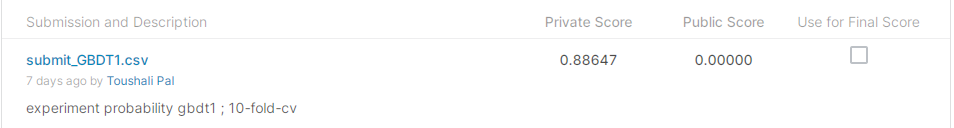

In [ ]:
Image(filename='/content/file-5.2-best-score.PNG')

In [ ]:
print("Best Model's Serial Number:",np.argsort([0.88647,0.88647,0.88703,0.88695,0.88706])[0])

Best Model's Serial Number: 0


Conclusion: The GBDT models with RandomizedSearchCV hyper-parameter tuning of max_depth, n_estimators, learning_rate worked best with Private Kaggle Leaderboard Score:0.88647. And this is the best model amongst all models. This submission falls in the top 2% of the leaderboard submissions. So this will be selected for creating the production pipeline as well! 😃



---



---



---



---



---



---



---



<font color="red">A mini-note for running the best model obtained in my local machine:</font> I don't have gpu in my local machine. So, the gbdt models trained above aren't giving proper results since they've been trained on GPU, here in colab. They are either just predicting same value for every query point or issues are occuring while loading the models. Hence, I'll train the best model obtained above on CPU here, in colab and save them again, just to get an overview as to how the production pipeline that I create, perform over query points on my local machine.<br>
Note: This won't be requred in real world since appropriate resources will be present over there.

In [ ]:
# firstly, xgboost version needs to be upgraded since my local machine has version 1.4.2 and here in colab, it is 0.9.
# this is to avoid the below error:-
# /workspace/src/learner.cc:682: Check failed: header == serialisation_header_:

In [ ]:
import xgboost
xgboost.__version__

'0.90'

In [ ]:
!pip uninstall xgboosty

Found existing installation: xgboost 0.90
Uninstalling xgboost-0.90:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/xgboost-0.90.dist-info/*
    /usr/local/lib/python3.7/dist-packages/xgboost/*
    /usr/local/xgboost/libxgboost.so
Proceed (y/n)? y
  Successfully uninstalled xgboost-0.90


In [ ]:
!pip install xgboost==1.4.2

     |████████████████████████████████| 166.7 MB 12 kB/s 


In [ ]:
import xgboost
xgboost.__version__

'1.4.2'

In [ ]:
# version is now same as my local machine

In [ ]:
#new
cls_model = XGBClassifier(n_jobs=-1,
                          n_estimators=100, max_depth=4, learning_rate=0.1)

reg_model = XGBRegressor(n_jobs=-1, objective="reg:squarederror",
                         n_estimators=100, max_depth=4, learning_rate=0.001)

In [ ]:
#new
%%time
cls_model.fit(trainX_cls,trainY_cls)

[13:02:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 26min 5s, sys: 4.19 s, total: 26min 9s
Wall time: 6min 48s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
#new
%%time
reg_model.fit(trainX_reg,trainY_reg)

CPU times: user 6.77 s, sys: 30.9 ms, total: 6.8 s
Wall time: 1.75 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.001, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
#new
# saving the model:-
filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files_2/models_4.1/cpu_gbdt_cls_model_newxgb.pkl'
pickle.dump(cls_model, open(filename, 'wb'))

filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files_2/models_4.1/cpu_gbdt_reg_model_newxgb.pkl'
pickle.dump(reg_model, open(filename, 'wb'))

In [ ]:
# both the problems are now solved:-
# 1. xgb version upgraded
# 2. the best models have been trained on cpu

# <font color="#1b5776">6. <u>Additional References</u></font>

In [ ]:
# https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

# https://scikit-learn.org/stable/modules/model_evaluation.html#:~:text=higher%20return%20values%20are%20better%20than%20lower%20return%20values
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

# https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/
# https://xgboost.readthedocs.io/en/stable/python/python_api.html
# https://xgboost.readthedocs.io/en/stable/parameter.html

# https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html#sklearn.ensemble.StackingRegressor

# https://stackoverflow.com/questions/43275506/scikit-learn-cross-val-predict-only-works-for-partitions
# https://datascience.stackexchange.com/questions/41378/how-to-apply-stacking-cross-validation-for-time-series-data/105116#105116

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# https://xgboost.readthedocs.io/en/stable/python/python_api.html#:~:text=class%20xgboost.XGBClassifier

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# https://xgboost.readthedocs.io/en/stable/python/python_api.html#:~:text=class%20xgboost.XGBRegressor

# https://stackoverflow.com/questions/48366506/calculate-new-column-as-the-mean-of-other-columns-pandas/48366525